In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, features

pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_columns", 100)

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")
odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [3]:
df2 = my_modules.preprocessing(df)

In [4]:
df3 = my_modules.common_process(df2)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:76: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252411 entries, 252634 to 0
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   race_id              252411 non-null  int64         
 1   year                 252411 non-null  int64         
 2   month                252411 non-null  int64         
 3   day                  252411 non-null  int64         
 4   times                252411 non-null  int64         
 5   place                252411 non-null  object        
 6   daily                252411 non-null  object        
 7   race_num             252411 non-null  int64         
 8   horse                252411 non-null  object        
 9   jockey_id            252411 non-null  object        
 10  trainer_id           252411 non-null  int64         
 11  horse_N              252411 non-null  object        
 12  waku_num             252411 non-null  int64         
 13  horse_num          

In [6]:
df3.head()

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,target,target3
252634,202001050601010115,2020,1,5,1,中山,1,1,ラブカワールド,1177,1131,16,8,15,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,436.0,4.0,3,474.2,355.9,15,254.1,14,153.0,39.3,115.2,36.0,15,74.6,30.0,14,13,2.0,1153,NaN,NaN,15.0,16.0,39.9,9,35.4,38.7,40.57,36.0,1.5,後方,15.0,0,0,トゥザワールド,ラブカテリーナ,オレハマッテルゼ,ロイヤルチャージャー系,黒鹿,2017104350,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,0,0
252635,202001050601010116,2020,1,5,1,中山,1,1,シラカワカツコ,1173,1031,16,8,16,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,404.0,4.0,3,233.1,239.5,13,197.1,13,83.6,21.6,62.3,19.6,13,30.6,12.4,12,14,2.1,1154,NaN,NaN,9.0,10.0,40.4,13,35.0,36.6,40.57,36.0,1.1,中団,13.0,0,0,ディープブリランテ,シャイニングピサ,Smart Strike,ネイティヴダンサー系,鹿毛,2017101747,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,0,0
252633,202001050601010102,2020,1,5,1,中山,1,1,スルーザリミッツ,1122,1118,16,1,2,7,24,2,1200,良,晴,12,牝,3,54.0,NaN,424.0,-4.0,3,31.4,31.1,7,22.6,6,13.7,3.9,11.3,3.8,7,7.4,3.2,6,12,1.6,1149,NaN,NaN,16.0,15.0,39.3,6,35.6,40.6,40.57,36.0,1.7,後方,7.0,0,0,パイロ,ファービヨンド,ディープスカイ,ロイヤルチャージャー系,黒鹿,2017101861,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,0,0
252632,202001050601010104,2020,1,5,1,中山,1,1,セルレア,1161,1115,16,2,4,7,24,2,1200,良,晴,12,牝,3,53.0,NaN,464.0,10.0,3,14.5,15.7,4,19.5,5,7.3,2.2,6.2,2.2,5,6.1,2.7,5,11,1.6,1149,NaN,NaN,6.0,6.0,40.2,11,34.7,36.3,40.57,36.0,0.8,中団,4.0,0,0,ロードカナロア,ダイワミストレス,ダイワメジャー,ロイヤルチャージャー系,鹿毛,2017102095,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,0,0
252631,202001050601010109,2020,1,5,1,中山,1,1,サノレーヌ,1164,1141,16,5,9,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,438.0,0.0,3,9.5,8.0,3,6.8,3,4.5,1.5,3.9,1.5,3,3.1,1.5,3,10,1.5,1148,NaN,NaN,1.0,1.0,40.9,15,33.9,32.9,40.57,36.0,0.0,逃げ,3.0,0,0,サウスヴィグラス,アニマートホウヨウ,フサイチコンコルド,ニアークティック系,鹿毛,2017100847,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,0,0


In [7]:
feature_col = ["waku_num", "horse_num", "sex", "age", "basis_weight", "weight", "inc_dec"]
df4, feature_col2 = features.feature_engineering(df3, feature_col)

calculating trueskill of horse is processing
calculating trueskill of jockey is processing


C:\Users\ken05\Documents\others\HORSE_RACING\Modules\features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_ranking"] = group[col].rank(ascending=False, method="min")
C:\Users\ken05\Documents\others\HORSE_RACING\Modules\features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_ranking"] = group[col].rank(ascending=False, method="min")
C:\Users\ken05\Documents\others\HORSE_RACING\Modules\features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'weight', 'inc_dec', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'all_win_rate_horse', 'all_win_rate3_horse', 'horse_win_rate_dist', 'horse_win_rate3_dist', 'horse_win_rate_track_code', 'horse_win_rate3_track_code', 'horse_win_rate_field_type', 'horse_win_rate3_field_type', 'horse_win_rate_turn_type', 'horse_win_rate3_turn_type', 'horse_win_rate_weather', 'horse_win_rate3_weather', 'horse_win_rate_state', 'horse_win_rate3_state', 'horse_win_rate_place', 'horse_win_rate3_place', 'horse_win_rate_corner_num', 'horse_win_rate3_corner_num', 'horse_win_rate_class_c

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_ranking"] = group[col].rank(ascending=False, method="min")


,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,target,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,horse_win_rate_dist,horse_win_rate3_dist,horse_win_rate_track_code,horse_win_rate3_track_code,horse_win_rate_field_type,horse_win_rate3_field_type,horse_win_rate_turn_type,horse_win_rate3_turn_type,horse_win_rate_weather,horse_win_rate3_weather,horse_win_rate_state,horse_win_rate3_state,horse_win_rate_place,horse_win_rate3_place,horse_win_rate_corner_num,horse_win_rate3_corner_num,horse_win_rate_class_code,horse_win_rate3_class_code,horse_win_rate_basis_weight,horse_win_rate3_basis_weight,horse_win_rate_age_code,horse_win_rate3_age_code,horse_win_rate_weight_code,horse_win_rate3_weight_code,horse_win_rate_jockey_id,horse_win_rate3_jockey_id,horse_win_rate_jockey_id_field_type,horse_win_rate3_jockey_id_field_type,horse_win_rate_weather_state,horse_win_rate3_weather_state,horse_win_rate_dist_corner_num,horse_win_rate3_dist_corner_num,horse_win_rate_dist_track_code,horse_win_rate3_dist_track_code,horse_win_rate_dist_class_code,horse_win_rate3_dist_class_code,horse_win_rate_place_field_type_dist,horse_win_rate3_place_field_type_dist,all_win_rate_horse,all_win_rate3_horse,all_win_rate_dist_waku,all_win_rate3_dist_waku,all_win_rate_field_type_waku,all_win_rate3_field_type_waku,all_win_rate_place_waku,all_win_rate3_place_waku,all_win_rate_field_type_dist_waku,all_win_rate3_field_type_dist_waku,all_win_rate_dist_place_waku,all_win_rate3_dist_place_waku,all_win_rate_field_type_place_waku,all_win_rate3_field_type_place_waku,all_win_rate_race_type_waku,all_win_rate3_race_type_waku,all_win_rate_corner_num_waku,all_win_rate3_corner_num_waku,all_win_rate_corner_num_dist_waku,all_win_rate3_corner_num_dist_waku,all_win_rate_corner_num_place_waku,all_win_rate3_corner_num_place_waku,all_win_rate_corner_num_field_type_waku,all_win_rate3_corner_num_field_type_waku,all_win_rate_jockey_id,all_win_rate3_jockey_id,all_win_rate_jockey_id_place,all_win_rate3_jockey_id_place,all_win_rate_jockey_id_place_dist,all_win_rate3_jockey_id_place_dist,all_win_rate_jockey_id_field_type,all_win_rate3_jockey_id_field_type,all_win_rate_jockey_id_field_type_dist,all_win_rate3_jockey_id_field_type_dist,all_win_rate_jockey_id_field_type_place,all_win_rate3_jockey_id_field_type_place,all_win_rate_jockey_id_dist,all_win_rate3_jockey_id_dist,all_win_rate_jockey_id_race_type,all_win_rate3_jockey_id_race_type,all_win_rate_jockey_id_race_type_waku,all_win_rate3_jockey_id_race_type_waku,all_win_rate_jockey_id_class_code,all_win_rate3_jockey_id_class_code,all_win_rate_jockey_id_class_code_place,all_win_rate3_jockey_id_class_code_place,all_win_rate_jockey_id_class_code_dist,all_win_rate3_jockey_id_class_code_dist,all_win_rate_jockey_id_class_code_field_type,all_win_rate3_jockey_id_class_code_field_type,all_win_rate_jockey_id_class_code_race_type,all_win_rate3_jockey_id_class_code_race_type,all_win_rate_jockey_id_class_code_race_type_waku,all_win_rate3_jockey_id_class_code_race_type_waku,all_win_rate_

In [9]:
df4[feature_col2]

,waku_num,horse_num,sex,age,basis_weight,weight,inc_dec,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,all_win_rate_horse,all_win_rate3_horse,horse_win_rate_dist,horse_win_rate3_dist,horse_win_rate_track_code,horse_win_rate3_track_code,horse_win_rate_field_type,horse_win_rate3_field_type,horse_win_rate_turn_type,horse_win_rate3_turn_type,horse_win_rate_weather,horse_win_rate3_weather,horse_win_rate_state,horse_win_rate3_state,horse_win_rate_place,horse_win_rate3_place,horse_win_rate_corner_num,horse_win_rate3_corner_num,horse_win_rate_class_code,horse_win_rate3_class_code,horse_win_rate_basis_weight,horse_win_rate3_basis_weight,horse_win_rate_age_code,horse_win_rate3_age_code,horse_win_rate_weight_code,horse_win_rate3_weight_code,horse_win_rate_jockey_id,horse_win_rate3_jockey_id,horse_win_rate_jockey_id_field_type,horse_win_rate3_jockey_id_field_type,horse_win_rate_weather_state,horse_win_rate3_weather_state,horse_win_rate_dist_corner_num,horse_win_rate3_dist_corner_num,horse_win_rate_dist_track_code,horse_win_rate3_dist_track_code,horse_win_rate_dist_class_code,horse_win_rate3_dist_class_code,horse_win_rate_place_field_type_dist,horse_win_rate3_place_field_type_dist,all_win_rate_dist_waku,all_win_rate3_dist_waku,all_win_rate_field_type_waku,all_win_rate3_field_type_waku,all_win_rate_place_waku,all_win_rate3_place_waku,all_win_rate_field_type_dist_waku,all_win_rate3_field_type_dist_waku,all_win_rate_dist_place_waku,all_win_rate3_dist_place_waku,all_win_rate_field_type_place_waku,all_win_rate3_field_type_place_waku,all_win_rate_race_type_waku,all_win_rate3_race_type_waku,all_win_rate_corner_num_waku,all_win_rate3_corner_num_waku,all_win_rate_corner_num_dist_waku,all_win_rate3_corner_num_dist_waku,all_win_rate_corner_num_place_waku,all_win_rate3_corner_num_place_waku,all_win_rate_corner_num_field_type_waku,all_win_rate3_corner_num_field_type_waku,all_win_rate_jockey_id,all_win_rate3_jockey_id,all_win_rate_jockey_id_place,all_win_rate3_jockey_id_place,all_win_rate_jockey_id_place_dist,all_win_rate3_jockey_id_place_dist,all_win_rate_jockey_id_field_type,all_win_rate3_jockey_id_field_type,all_win_rate_jockey_id_field_type_dist,all_win_rate3_jockey_id_field_type_dist,all_win_rate_jockey_id_field_type_place,all_win_rate3_jockey_id_field_type_place,all_win_rate_jockey_id_dist,all_win_rate3_jockey_id_dist,all_win_rate_jockey_id_race_type,all_win_rate3_jockey_id_race_type,all_win_rate_jockey_id_race_type_waku,all_win_rate3_jockey_id_race_type_waku,all_win_rate_jockey_id_class_code,all_win_rate3_jockey_id_class_code,all_win_rate_jockey_id_class_code_place,all_win_rate3_jockey_id_class_code_place,all_win_rate_jockey_id_class_code_dist,all_win_rate3_jockey_id_class_code_dist,all_win_rate_jockey_id_class_code_field_type,all_win_rate3_jockey_id_class_code_field_type,all_win_rate_jockey_id_class_code_race_type,all_win_rate3_jockey_id_class_code_race_type,all_win_rate_jockey_id_class_code_race_type_waku,all_win_rate3_jockey_id_class_code_race_type_waku,all_win_rate_jockey_id_turn_type,all_win_rate3_jockey_id_turn_type,all_win_rate_jockey_id_turn_type_dist,all_win_rate3_jockey_id_turn_type_dist,all_win_rate_jockey_id_turn_type_place,all_win_rate3_jockey_id_turn_type_place,all_win_rate_jockey_id_turn_type_field_type,all_win_rate3_jockey_id_turn_type_field_type,all_win_rate_jockey_id_turn_type_dist_place,all_win_rate3_jockey_id_turn_type_dist_place,all_win_rate_jockey_id_turn_type_dist_field_type,all_win_rate3_jockey_id_turn_type_dist_field_type,all_win_rate_jockey_id_turn_type_place_field_type,all_win_rate3_jockey_id_turn_type_place_field_type,all_win_rate_jockey_id_turn_type_dist_waku,all_win_rate3_jockey_id_turn_type_dist_waku,all_w

[I 2025-06-27 21:00:07,776] A new study created in memory with name: no-name-026bd2ae-8dba-4ca7-b2f5-08cbd0d721f1
[I 2025-06-27 21:00:15,594] Trial 0 finished with value: 0.21962500173173402 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.3248149123539492, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.7579479953348001, 'path_smooth': 8.324426408004218}. Best is trial 0 with value: 0.21962500173173402.
[I 2025-06-27 21:00:41,701] Trial 1 finished with value: 0.2116715631095116 and parameters: {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lambda

Best params :  {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lambda_l2': 1.8007140198129195e-07, 'min_gain_to_split': 2.9214464853521815, 'max_depth': 38, 'learning_rate': 0.006672367170464205, 'path_smooth': 7.851759613930136}


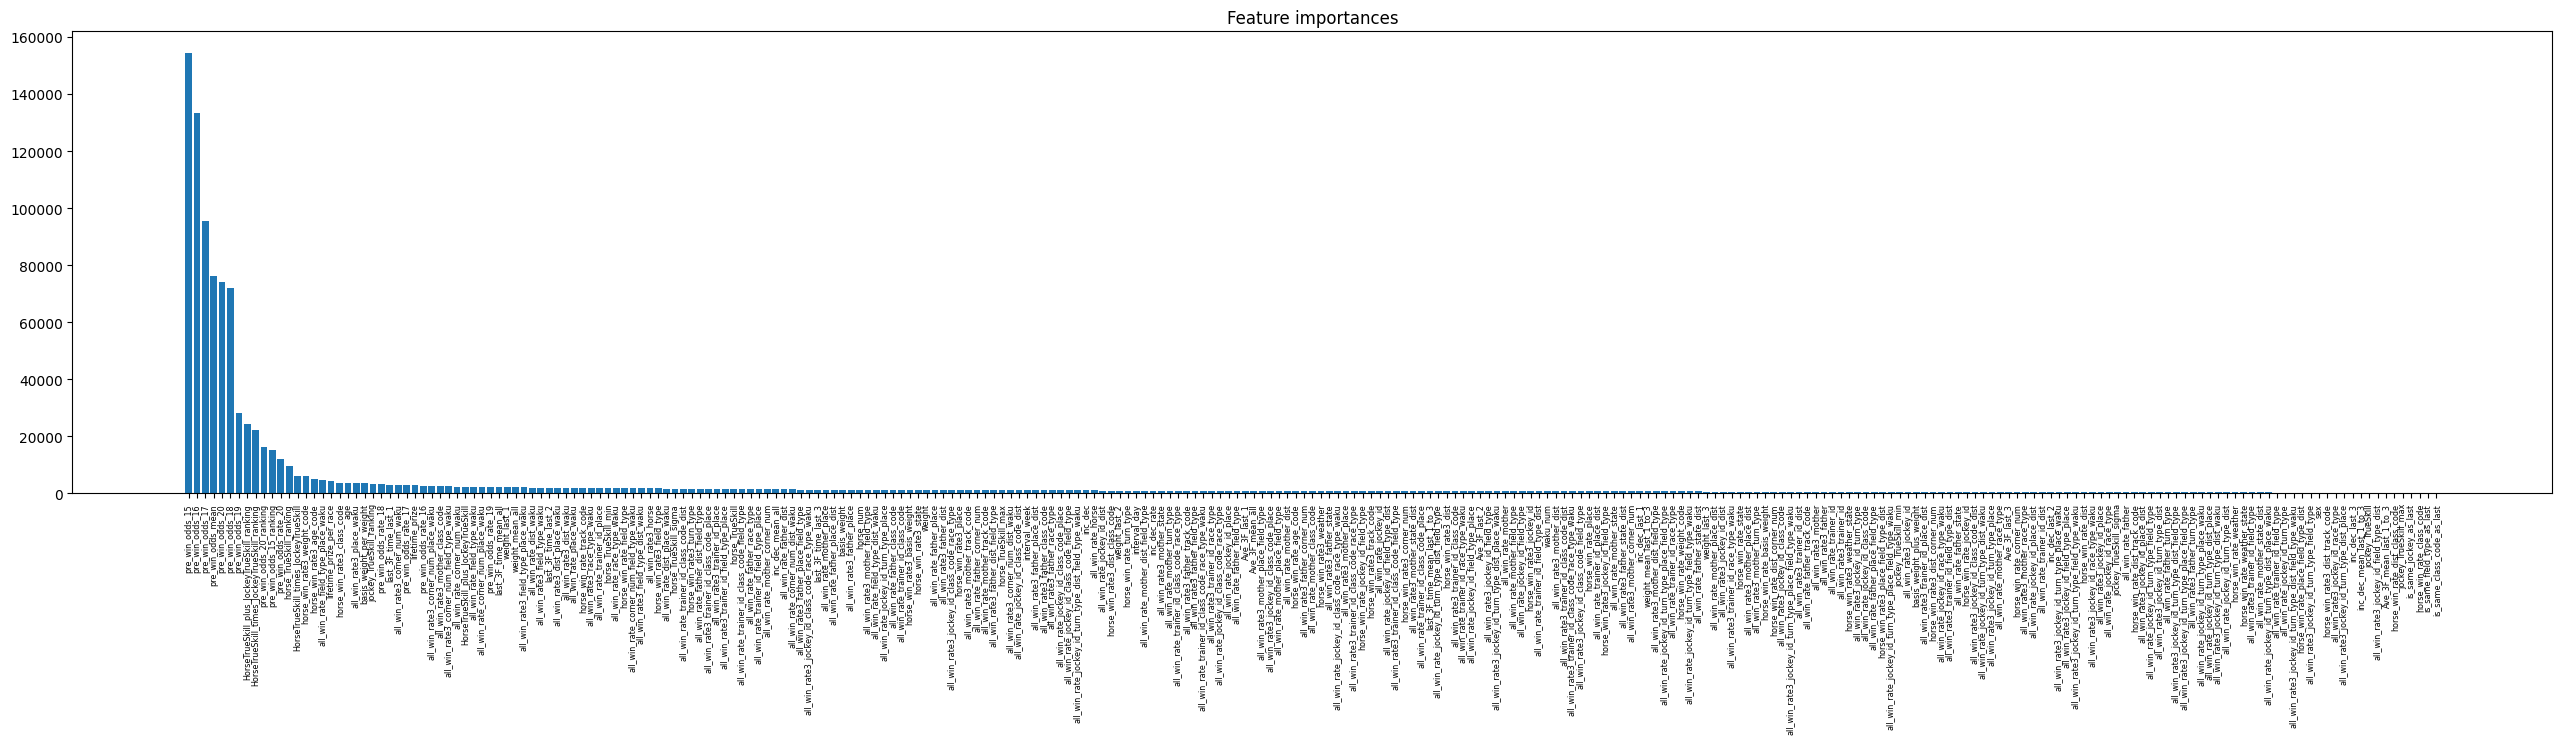

In [8]:
memo = "add TrueSkill(sigma, max, min) in each racing, reduce features. n_rials=50."
model, df_pred = model_tuner.simple_lightGBM(df4, feature_col2, memo=memo, n_trials=3, save_result=False, visualization=True)

In [9]:
tmp =  df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False)
tmp.head(10)

,id_for_fold,horse,pred
207687,2024062302010605,ヤンキーバローズ,0.711461
233205,2025012506010806,クレーキング,0.668270
211595,2024072704020101,エンブロイダリー,0.665608
192710,2024030209010306,ハビレ,0.630156
223296,2024110205050112,ウインオーディン,0.610074
219812,2024100605040202,エデルクローネ,0.601499
208594,2024063010030206,シルフズミスチーフ,0.601020
177850,2023110505050204,ボーモンド,0.594997
205912,2024060908040409,インザモーメント,0.588251
217523,2024091507030402,オトメナシャチョウ,0.575967


In [10]:
df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False).tail()

,id_for_fold,horse,pred
209287,2024070710030401,イチザマジック,0.001566
199106,2024042005020104,ビューティビースト,0.001561
205778,2024060905030406,ラテラルアーク,0.001494
192681,2024030206020305,ソーリャ,0.001426
187027,2024012006010606,ホークビッツ,0.001404


In [11]:
df_pred[["race_id", "id_for_fold", "horse", "pred", "win_odds", "target"]].to_csv("df_pred.csv", index=False)